In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Out of core text classification with the Hashing Vectorizer

Using the Amazon movie reviews collected by J. McAuley and J. Leskovec

https://snap.stanford.edu/data/web-Movies.html

In [2]:
import os
print("file size: %d GB" % (os.path.getsize("data/movies.txt") / 1024 ** 3))

file size: 8 GB


In [3]:
with open("data/movies.txt") as f:
    print(f.read(4000))

product/productId: B003AI2VGA
review/userId: A141HP4LYPWMSR
review/profileName: Brian E. Erland "Rainbow Sphinx"
review/helpfulness: 7/7
review/score: 3.0
review/time: 1182729600
review/summary: "There Is So Much Darkness Now ~ Come For The Miracle"
review/text: Synopsis: On the daily trek from Juarez, Mexico to El Paso, Texas an ever increasing number of female workers are found raped and murdered in the surrounding desert. Investigative reporter Karina Danes (Minnie Driver) arrives from Los Angeles to pursue the story and angers both the local police and the factory owners who employee the undocumented aliens with her pointed questions and relentless quest for the truth.<br /><br />Her story goes nationwide when a young girl named Mariela (Ana Claudia Talancon) survives a vicious attack and walks out of the desert crediting the Blessed Virgin for her rescue. Her story is further enhanced when the "Wounds of Christ" (stigmata) appear in her palms. She also claims to have received a me

In [4]:
def review_iter(f):
    current_post = []
    for line in f.readlines():
        if line.startswith("product/productId"):
            if len(current_post):
                score = current_post[3].strip("review/score: ").strip()
                review = "".join(current_post[6:]).strip("review/text: ").strip()
                yield int(float(score)), review
            current_post = []
        else:
            current_post.append(line)

In [5]:
n_reviews = 0
with open("data/movies.txt") as f:
    for r in review_iter(f):
        n_reviews += 1
print("Number of reviews: %d" % n_reviews)

Number of reviews: 112625


In [6]:
from itertools import islice

with open("data/movies.txt") as f:
    reviews = islice(review_iter(f), 10000)
    scores, texts = zip(*reviews)
print(np.bincount(scores))

[   0  743  581 1020 2048 5608]


In [7]:
from itertools import izip_longest
# from the itertools recipes
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    args = [iter(iterable)] * n
    return izip_longest(fillvalue=fillvalue, *args)

In [8]:
def preprocess_batch(reviews):
    reviews_filtered = [r for r in reviews if r is not None and r[0] != 3]
    scores, texts = zip(*reviews_filtered)
    polarity = np.array(scores) > 3
    return polarity, texts

In [9]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(decode_error="ignore")

with open("data/movies.txt") as f:
    reviews = islice(review_iter(f), 10000)
    polarity_test, texts_test = preprocess_batch(reviews)
    X_test = vectorizer.transform(texts_test)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=0)

accuracies = []
with open("data/movies.txt") as f:
    training_set = islice(review_iter(f), 10000, None)
    batch_iter = grouper(training_set, 10000)
    for batch in batch_iter:
        polarity, texts = preprocess_batch(batch)
        X = vectorizer.transform(texts)
        sgd.partial_fit(X, polarity, classes=[0, 1])
        accuracies.append(sgd.score(X_test, polarity_test))

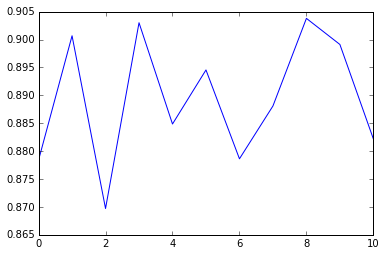

In [11]:
plt.plot(accuracies)